In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import copy as cp

In [2]:
print(cv2.__version__)

4.5.5


In [3]:
img_path = "./10_kanugovimahidhar_mask.png"

In [4]:
image = cv2.imread(img_path)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

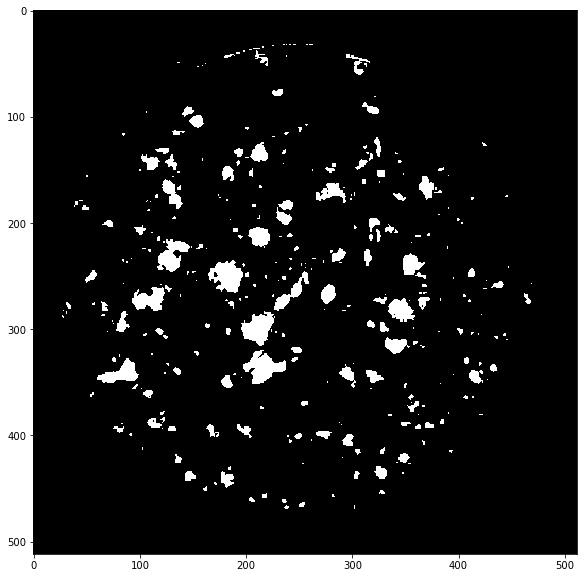

In [5]:
image_thresholded = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
plt.figure(figsize=(10,10))
plt.imshow(image_thresholded, cmap = 'gray')

In [6]:
numLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(image_thresholded)

In [7]:
label_idx = 137


# label_idx = 14

# label_idx = 12
# label_idx = 1

[182.17076923 250.02      ]


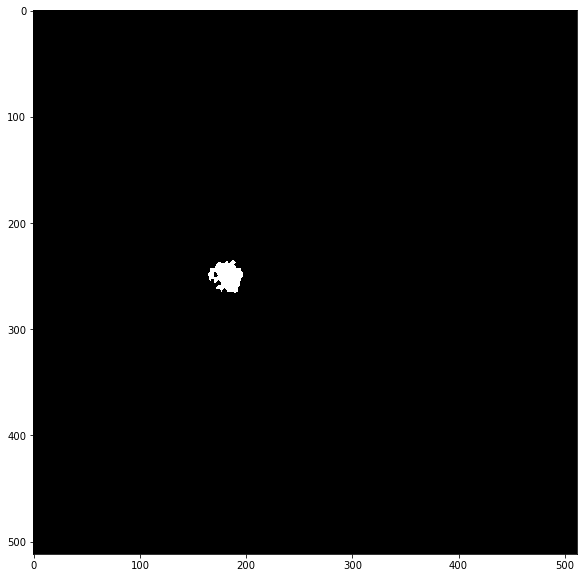

In [8]:
single_CC = np.zeros_like(labels)
single_CC = np.where(labels==label_idx, 255, 0).astype("uint8")
plt.figure(figsize=(10,10))
plt.imshow(single_CC, cmap = 'gray')

print(centroids[label_idx])

In [9]:
single_CC_contours, hierarchy = cv2.findContours(single_CC, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

print(hierarchy)
print(len(single_CC_contours))

[[[-1 -1 -1 -1]]]
1


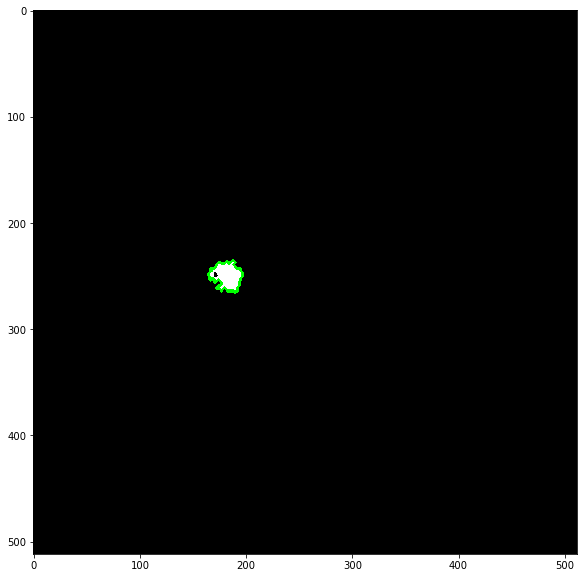

In [10]:
single_CC_rgb = cv2.cvtColor(single_CC, cv2.COLOR_GRAY2RGB)

single_CC_contoured = cv2.drawContours(cp.deepcopy(single_CC_rgb), single_CC_contours[0], -1, (0, 255, 0), 2)
plt.figure(figsize=(10,10))
plt.imshow(single_CC_contoured)

In [11]:
(x,y), radius = cv2.minEnclosingCircle(single_CC_contours[0])
print(f"x: {x}, y:{y}")
print(f"radius: {radius}")

x: 181.6710662841797, y:250.64881896972656
radius: 16.880292892456055


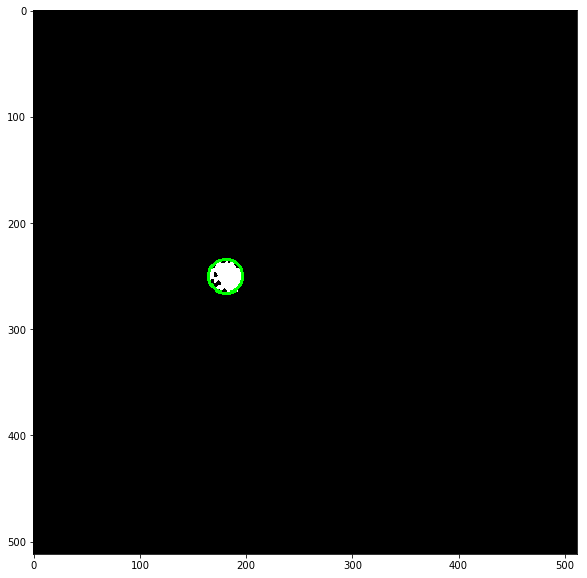

In [12]:
single_CC_circle = cv2.circle(cp.deepcopy(single_CC_rgb), (int(x),int(y)), int(radius),(0,255,0), 2)
plt.figure(figsize=(10,10))
plt.imshow(single_CC_circle)

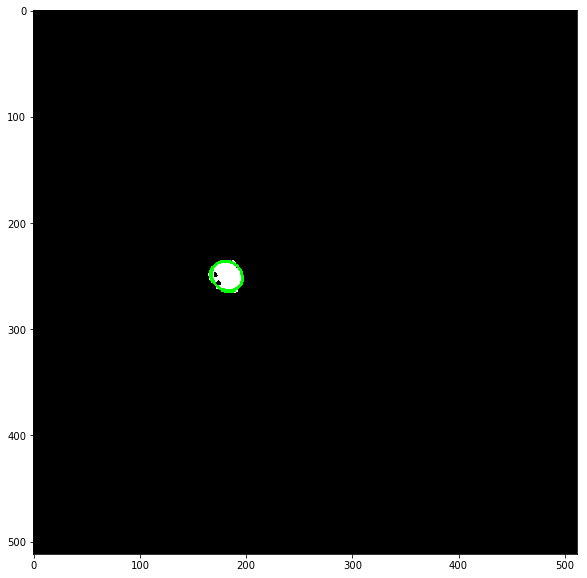

In [13]:
ellipse = cv2.fitEllipse(single_CC_contours[0])
single_CC_ellipse = cv2.ellipse(cp.deepcopy(single_CC_rgb) ,ellipse, (0,255,0), 2)
plt.figure(figsize=(10,10))
plt.imshow(single_CC_ellipse)

x: 180.96897888183594, y: 249.3724365234375, w: 29.81332778930664, h: 32.05555725097656, angle: 4.763641834259033


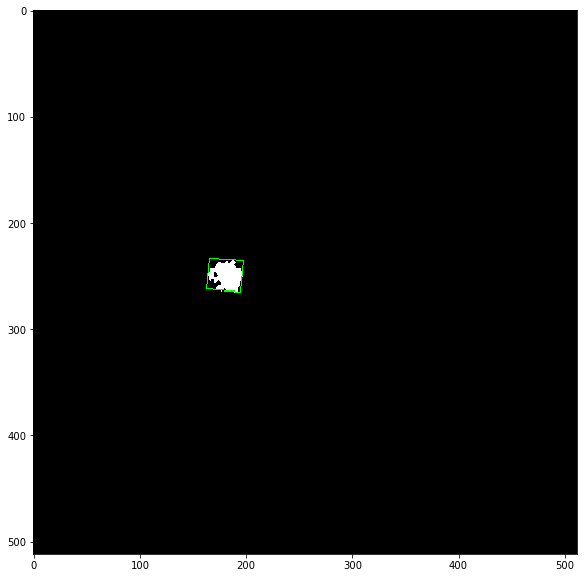

In [14]:
rect = cv2.minAreaRect(single_CC_contours[0])

((x, y), (h, w), angle) = rect

print(f"x: {x}, y: {y}, w: {w}, h: {h}, angle: {angle}")

box = cv2.boxPoints(rect)
box = np.int0(box)
single_CC_rect = cv2.drawContours(cp.deepcopy(single_CC_rgb),[box],0,(0,255,0),1)

plt.figure(figsize=(10,10))
plt.imshow(single_CC_rect)

In [15]:
def fix_theta(angle, w, h):
    if w < h:
        print("Width Less")
        inter = 90 - angle
        angle = inter + 180
    else: 
        print("Width Greater")
        angle = -angle
            
    return angle

In [16]:
angle = fix_theta(angle, w, h)
print(angle)
# angle = 315

Width Less
265.23635816574097


In [17]:
def generate_2d_gaussian(x_center = 0, 
                  y_center = 0, 
                  radius = 1, 
                  alpha = 0.1,
                  angle = 0, 
                  out_size = (256, 256)):
    
    """
    x_center: x coordinate of gaussian center
    y_center: y coordinate of gaussian center
    radius: Farthest distance from center of CC to contour
    alpha: parameter to adjust standard deviation of 2D gaussian
    angle: the angle to rotate 2D gaussian axis
    out_size: H x W of output 2D gaussian heatmap
    """
    print("angle: ", angle)
    ## Convert to radi
    theta = (np.pi*angle) / 180
    print("theta: ", theta)
    
    ## Generate rows and columns labels
    x = np.arange(0, out_size[0], dtype = int)
    y = np.arange(0, out_size[1], dtype = int)

    
    ## Generate meshgrid
    xv, yv = np.meshgrid(x, y)    
#     print(xv.shape)
#     print(yv.shape)
    
    ## Compte sigma for x and y axis
    x_sigma = radius * alpha
    y_sigma = radius * alpha * 2 
    
    
    ## Compute rotation coefficients, according to https://en.wikipedia.org/wiki/Gaussian_function
    
    a = ((np.power(np.cos(theta), 2)) / (2 * np.power(x_sigma, 2))) + \
        ((np.power(np.sin(theta), 2)) / (2 * np.power(y_sigma, 2)))
    
    b = -(np.sin(2 * theta) / (4 * np.power(x_sigma, 2))) + \
         (np.sin(2 * theta) / (4 * np.power(y_sigma, 2)))
    
    c = ((np.power(np.sin(theta), 2)) / (2 * np.power(x_sigma, 2))) + \
        ((np.power(np.cos(theta), 2)) / (2 * np.power(y_sigma, 2)))
    
    ## Generate rotated 2D gaussian map
    
    gauss_map = np.exp(-( (a*np.power(xv-x_center, 2)) + (2*b*(xv-x_center)*(yv-y_center)) + (c*np.power((yv-y_center),2))))
#     print(gauss_map.shape)
    
    return gauss_map

In [18]:
test = generate_2d_gaussian(x_center = int(x), 
                     y_center = int(y), 
                     radius = radius, 
                     alpha = 0.4,
                     angle = angle,
                     out_size = single_CC.shape
                     )

angle:  265.23635816574097
theta:  4.629247745991127


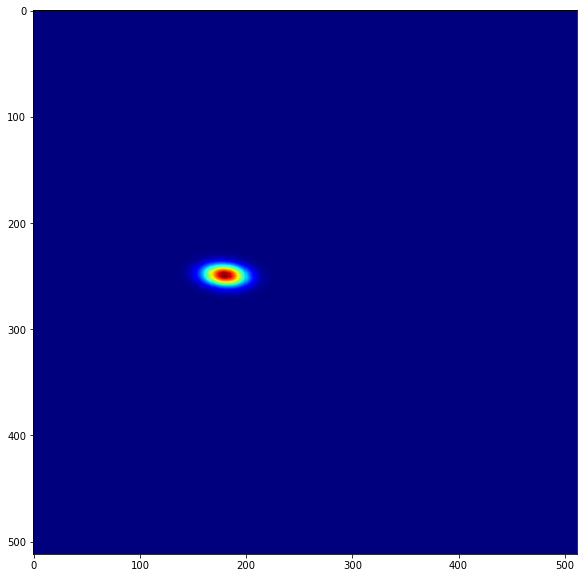

In [19]:
plt.figure(figsize=(10,10))
plt.imshow(test, cmap = 'jet')

In [ ]:
# def makeGaussian2(x_center = 0, 
#                   y_center = 0, 
#                   radius = 1, 
#                   alpha = 0.1,
#                   angle = 0, 
#                   out_size = (256, 256)):
    
#     """
#     x_center: x coordinate of gaussian center
#     y_center: y coordinate of gaussian center
#     radius: Farthest distance from center of CC to contour
#     alpha: parameter to adjust standard deviation of 2D gaussian
#     angle: the angle to rotate 2D gaussian axis
#     out_size: H x W of output 2D gaussian heatmap
#     """
    
#     ## Convert to radian
#     theta = 2*np.pi*angle/360
    
#     x = np.arange(0, out_size[0], 1, float)
# #     print(x.shape)
# #     print(x)
    
    
#     y = np.arange(0, out_size[1], 1, float)
# #     print(y.shape)
# #     print(y)
    
#     y = y[:, np.newaxis]
    
# #     print(y.shape)
# #     print(y)
    
#     sx = radius * alpha
#     sy = radius * alpha * 2
    
#     x0 = x_center
#     y0 = y_center

#     # rotation
#     a = np.cos(theta)*x - np.sin(theta)*y
#     b = np.sin(theta)*x + np.cos(theta)*y
#     a0 = np.cos(theta)*x0 - np.sin(theta)*y0
#     b0 = np.sin(theta)*x0 + np.cos(theta)*y0

#     return np.exp(-(((a-a0)**2)/(2*(sx**2)) + ((b-b0)**2) /(2*(sy**2))))

In [ ]:
# ##From:  https://stackoverflow.com/questions/7687679/how-to-generate-2d-gaussian-with-python


# def makeGaussian2(x_center=0, y_center=0, theta=0, sigma_x = 10, sigma_y=10, x_size=640, y_size=480):
#     # x_center and y_center will be the center of the gaussian, theta will be the rotation angle
#     # sigma_x and sigma_y will be the stdevs in the x and y axis before rotation
#     # x_size and y_size give the size of the frame 

#     theta = 2*np.pi*theta/360
#     x = np.arange(0,x_size, 1, float)
#     y = np.arange(0,y_size, 1, float)
#     y = y[:,np.newaxis]
#     sx = sigma_x
#     sy = sigma_y
#     x0 = x_center
#     y0 = y_center

#     # rotation
#     a=np.cos(theta)*x -np.sin(theta)*y
#     b=np.sin(theta)*x +np.cos(theta)*y
#     a0=np.cos(theta)*x0 -np.sin(theta)*y0
#     b0=np.sin(theta)*x0 +np.cos(theta)*y0

#     return np.exp(-(((a-a0)**2)/(2*(sx**2)) + ((b-b0)**2) /(2*(sy**2))))